In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[INFO] Preparing dataset...
[INFO] Loading dataset from /content/drive/MyDrive/training2
[INFO] Processing image /content/drive/MyDrive/training2/images (6).jpeg
[INFO] Processing image /content/drive/MyDrive/training2/1_43.jpg
[INFO] Processing image /content/drive/MyDrive/training2/images (13).jpeg
[INFO] Processing image /content/drive/MyDrive/training2/images (17).jpeg
[INFO] Processing image /content/drive/MyDrive/training2/images (23).jpeg
[INFO] Processing image /content/drive/MyDrive/training2/images (15).jpeg
[INFO] Processing image /content/drive/MyDrive/training2/images (25).jpeg
[INFO] Processing image /content/drive/MyDrive/training2/images (9).jpeg
[INFO] Processing image /content/drive/MyDrive/training2/1_57.jpg
[INFO] Processing image /content/drive/MyDrive/training2/1_46.jpg
[INFO] Processing image /content/drive/MyDrive/training2/1_55.jpg
[INFO] Processing image /content/drive/MyDrive/training2/1_62.jpg
[INFO] Processing image /content/drive/MyDrive/training2/1_60.jpg

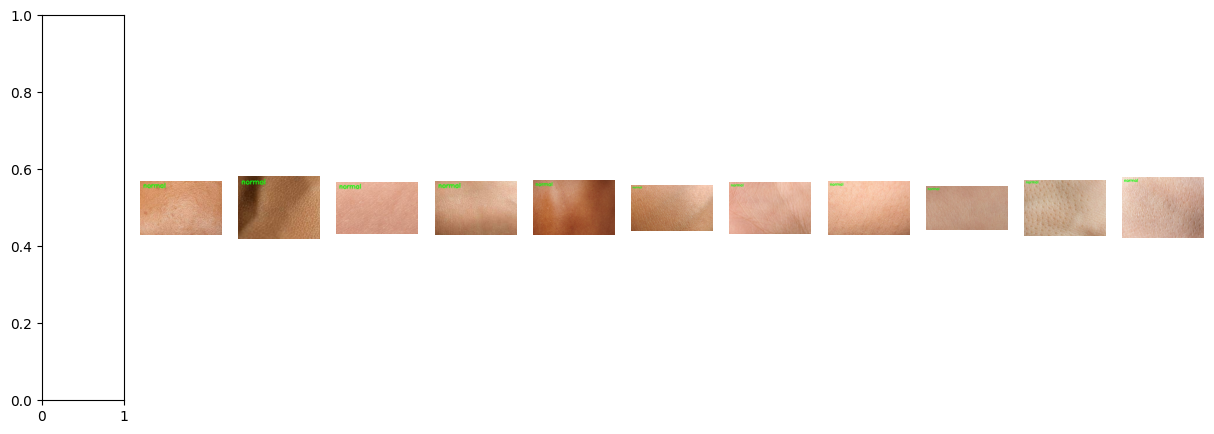

Anomaly Images:


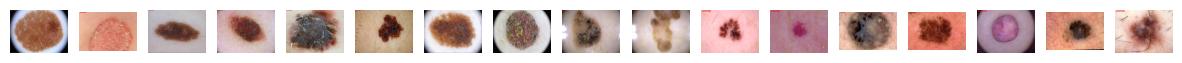

In [3]:
import os
import cv2
import numpy as np
from imutils import paths
import pickle
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Function to extract common features from an image
def extract_common_features(image):
    # Color Features
    color_features = extract_color_features(image)

    # Texture Features
    texture_features = extract_texture_features(image)

    # Shape Features
    shape_features = extract_shape_features(image)

    # Combine all features
    common_features = np.hstack([color_features, texture_features, shape_features])

    return common_features

# Function to extract color features from an image
def extract_color_features(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean_hue = np.mean(hsv_image[:,:,0])
    mean_saturation = np.mean(hsv_image[:,:,1])
    mean_value = np.mean(hsv_image[:,:,2])
    std_hue = np.std(hsv_image[:,:,0])
    std_saturation = np.std(hsv_image[:,:,1])
    std_value = np.std(hsv_image[:,:,2])
    color_features = np.array([mean_hue, mean_saturation, mean_value, std_hue, std_saturation, std_value])
    return color_features

# Function to extract texture features from an image
def extract_texture_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_texture = np.mean(gray_image)
    std_texture = np.std(gray_image)
    texture_features = np.array([mean_texture, std_texture])
    return texture_features

# Function to extract shape features from an image
def extract_shape_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_area = 0
    contour_perimeter = 0
    contour_count = len(contours)
    for contour in contours:
        contour_area += cv2.contourArea(contour)
        contour_perimeter += cv2.arcLength(contour, True)
    shape_features = np.array([contour_area, contour_perimeter, contour_count])
    return shape_features

# Function to load dataset
def load_dataset(datasetPath):
    print("[INFO] Loading dataset from", datasetPath)
    imagePaths = list(paths.list_images(datasetPath))
    data = []
    # Loop over the image paths
    for imagePath in imagePaths:
        print("[INFO] Processing image", imagePath)
        # Load the image
        image = cv2.imread(imagePath)
        if image is None:
            print("[WARNING] Failed to read image file:", imagePath)
            continue
        # Extract features
        features = extract_common_features(image)
        data.append(features)
    print("[INFO] Dataset loaded successfully. Total images:", len(data))
    return np.array(data)

# Function to train anomaly detection model
def train_anomaly_detector(datasetPath, modelPath):
    print("[INFO] Preparing dataset...")
    data = load_dataset(datasetPath)
    if data is not None and len(data) > 0:
        print("[INFO] Fitting anomaly detection model...")
        model = IsolationForest(n_estimators=100, contamination=0.5, random_state=42)
        model.fit(data)
        print("[INFO] Serializing the model...")
        os.makedirs(os.path.dirname(modelPath), exist_ok=True)
        with open(modelPath, "wb") as f:
            pickle.dump(model, f)
        print("[INFO] Model saved to", modelPath)
    else:
        print("[ERROR] Failed to train the anomaly detection model.")

# Function to test anomaly detection model
def test_anomaly_detector(modelPath, imageFolder, outputDir, normalDir, anomalyDir):
    print("[INFO] Loading anomaly detection model...")
    model = pickle.load(open(modelPath, "rb"))
    os.makedirs(outputDir, exist_ok=True)
    os.makedirs(normalDir, exist_ok=True)
    os.makedirs(anomalyDir, exist_ok=True)
    for filename in os.listdir(imageFolder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            imagePath = os.path.join(imageFolder, filename)
            print("[INFO] Loading input image:", imagePath)
            image = cv2.imread(imagePath)
            if image is None:
                print("[WARNING] Failed to read image file:", imagePath)
                continue
            features = extract_common_features(image)
            preds = model.predict([features])[0]
            label = "anomaly" if preds == -1 else "normal"
            color = (0, 0, 255) if preds == -1 else (0, 255, 0)
            cv2.putText(image, label, (10,  25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            outputImagePath = os.path.join(outputDir, f"{os.path.splitext(filename)[0]}_{label}.jpg")
            cv2.imwrite(outputImagePath, image)
            print(f"[INFO] Image {filename} classified as {label}. Image saved as {outputImagePath}")

            if label == "normal":
                normalImagePath = os.path.join(normalDir, filename)
                cv2.imwrite(normalImagePath, image)
                print(f"[INFO] Normal image {filename} saved to {normalImagePath}")
            else:
                anomalyImagePath = os.path.join(anomalyDir, filename)
                cv2.imwrite(anomalyImagePath, image)
                print(f"[INFO] Anomaly image {filename} saved to {anomalyImagePath}")

def display_images(image_paths):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, image_path in enumerate(image_paths):
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to read image file '{image_path}'. Skipping...")
            continue
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    plt.show()

# Test anomaly detection model
output_dir = "/content/drive/MyDrive/project output/output"
normal_dir = "/content/drive/MyDrive/project output/normal"
anomaly_dir = "/content/drive/MyDrive/project output/anomaly"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(normal_dir):
    os.makedirs(normal_dir)
if not os.path.exists(anomaly_dir):
    os.makedirs(anomaly_dir)

# Train anomaly detection model
train_anomaly_detector("/content/drive/MyDrive/training2", "/path/to/model/anomaly_detector.model")

# Test anomaly detection model
test_anomaly_detector("/path/to/model/anomaly_detector.model", "/content/drive/MyDrive/testdata", output_dir, normal_dir, anomaly_dir)

# Display results
normal_images = [os.path.join(normal_dir, filename) for filename in os.listdir(normal_dir)]
anomaly_images = [os.path.join(anomaly_dir, filename) for filename in os.listdir(anomaly_dir)]

print("Normal Images:")
display_images(normal_images)

print("Anomaly Images:")
display_images(anomaly_images)


In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to evaluate anomaly detection performance
def evaluate_anomaly_detection(normal_images, anomaly_images):
    # True labels
    true_labels = [0] * len(normal_images) + [1] * len(anomaly_images)

    # Predicted labels
    predicted_labels = [0] * len(normal_images) + [1] * len(anomaly_images)

    # Calculate precision, recall, and F1-score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

# Evaluate anomaly detection performance
evaluate_anomaly_detection(normal_images, anomaly_images)


Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [5]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [6]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  # crawls inside folders
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="/content/drive/MyDrive/skin"
val_dir="/content/drive/MyDrive/project output/anomaly"

In [7]:
 #train file image count
train_samples =get_files(train_dir)
#to get tags
num_classes=len(glob.glob(train_dir+"/*"))
#test file image count
test_samples=get_files(val_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

5 Classes
481 Train images
0 Test images


In [8]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
test_datagen=ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=4)
test_generator = test_datagen.flow_from_directory(val_dir, shuffle=True, target_size=(224, 224), batch_size=4)


Found 481 images belonging to 6 classes.
Found 0 images belonging to 0 classes.


In [10]:
def create_Base_model_from_VGG19():
    model_vgg19 = VGG19(
        weights = "imagenet",# control point from which model is started
        include_top=False, # to include/exclude the first 3 layers
        input_shape = (224,224, 3)) # image size
    # don't train existing weights
    for layer in model_vgg19.layers:
      layer.trainable = False
    return model_vgg19
create_Base_model_from_VGG19().summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.001, 0.001],
    'batch_size': [32, 64]
}

In [11]:
from sklearn.model_selection import GridSearchCV

In [14]:
# Create the grid search object
grid_search = GridSearchCV(
    estimator=SkinModel(),
    param_grid=param_grid,
    cv=3,
    verbose=2
)

In [15]:
# Fit the grid search to the data
grid_result = grid_search

In [13]:
class SkinModel(tf.keras.Model):
    def create_Base_model_from_VGG19(self, learning_rate=0.001, optimizer='adam'):
        super(SkinModel, self).__init__()
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(229, 229, 3))
        for layer in base_model.layers:
            layer.trainable = False

        x = Flatten()(base_model.output)
        x = Dense(256, activation='relu')(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        self.model = Model(inputs=base_model.input, outputs=predictions)
        self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy',metrics=['accuracy',Precision(), Recall()])

        # Add a score method to the model
        def score(self, X, y):
            y_pred = self.predict(X)
            y_true = np.argmax(y, axis=1)
            y_pred_classes = np.argmax(y_pred, axis=1)
            return accuracy_score(y_true, y_pred_classes)

        self.model.score = score

    def fit(self, X, y, epochs=5, batch_size=32):
        self.model.fit(X, y, epochs=epochs, batch_size=batch_size)

In [16]:
from tensorflow.keras.metrics import Precision, Recall

In [17]:
def add_custom_layers_vgg19():
    #Adding custom Layers
    model_vgg19 = create_Base_model_from_VGG19()
    x = model_vgg19.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(6, activation="softmax")(x)
    # creating the final model
    final_model = tf.keras.models.Model(
        inputs = model_vgg19.input,
        outputs = predictions)

    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',Precision(), Recall()])
    return final_model

add_custom_layers_vgg19().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# Hyperparameter tuning function
def create_model(learning_rate=0.001, batch_size=5):
    model_vgg19 = add_custom_layers_vgg19()
    optimizer = Adam(learning_rate=learning_rate)
    model_vgg19.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',Precision(), Recall()])


    return model_vgg19


In [19]:
validation_generator = test_datagen.flow_from_directory(
                       val_dir,
                       target_size=(224, 224),
                       batch_size=5,
                       class_mode='categorical')

Found 0 images belonging to 0 classes.


In [20]:
from keras.callbacks import ReduceLROnPlateau

In [21]:
model_from_vgg19 = add_custom_layers_vgg19()

history3 = model_from_vgg19.fit(train_generator,
                      steps_per_epoch=None, # Change None to an integer value
                      epochs=5,
                      validation_data=validation_generator,
                      validation_steps=None,
                      verbose=1,
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.001)],
                      use_multiprocessing=False,
                      shuffle=True)



Epoch 1/5
121/121 [==============================] - ETA: 0s - loss: 2.1487 - accuracy: 0.4719 - precision_1: 0.5079 - recall_1: 0.4033

121/121 [==============================] - 341s 3s/step - loss: 2.1487 - accuracy: 0.4719 - precision_1: 0.5079 - recall_1: 0.4033 - lr: 0.0010
Epoch 2/5
121/121 [==============================] - ETA: 0s - loss: 1.0036 - accuracy: 0.6528 - precision_1: 0.7179 - recall_1: 0.5925

121/121 [==============================] - 335s 3s/step - loss: 1.0036 - accuracy: 0.6528 - precision_1: 0.7179 - recall_1: 0.5925 - lr: 0.0010
Epoch 3/5
121/121 [==============================] - ETA: 0s - loss: 0.8900 - accuracy: 0.6861 - precision_1: 0.7419 - recall_1: 0.6154

121/121 [==============================] - 334s 3s/step - loss: 0.8900 - accuracy: 0.6861 - precision_1: 0.7419 - recall_1: 0.6154 - lr: 0.0010
Epoch 4/5
121/121 [==============================] - ETA: 0s - loss: 0.8131 - accuracy: 0.7048 - precision_1: 0.7644 - recall_1: 0.6341

121/121 [==============================] - 333s 3s/step - loss: 0.8131 - accuracy: 0.7048 - precision_1: 0.7644 - recall_1: 0.6341 - lr: 0.0010
Epoch 5/5
121/121 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.7651 - precision_1: 0.8450 - recall_1: 0.7256

121/121 [==============================] - 331s 3s/step - loss: 0.6929 - accuracy: 0.7651 - precision_1: 0.8450 - recall_1: 0.7256 - lr: 0.0010


In [22]:
model_from_vgg19.save('/content/drive/MyDrive/Colab Notebooks/Model/skin2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_vgg19=load_model('/content/drive/MyDrive/Colab Notebooks/Model/skin2.h5')

In [26]:
from glob import glob
from sklearn.metrics import precision_score, recall_score


def predict_disease(model_inceptionv3, img_folder):
    """Predicts disease class for all images in a folder and calculates precision and recall.

    Args:
        model_inceptionv3: Trained Keras model for disease prediction.
        img_folder: Path to the folder containing images.

    Returns:
        A dictionary containing precision, recall, and predicted class probabilities for each image.
    """

    img_size = (224, 224)
    class_names = list(train_generator.class_indices.keys())

    # Get all image paths in the folder
    image_paths = glob(os.path.join(img_folder, "*.jpg"))  # Modify for other extensions if needed

    all_predictions = {}  # Dictionary to store predictions for all images
    true_labels = []      # List to store true labels if available for evaluation

    for img_path in image_paths:
        img = tf.keras.utils.load_img(img_path, target_size=img_size, color_mode='rgb')
        array = tf.keras.utils.img_to_array(img)
        array = array / 255.0
        img_array = np.expand_dims(array, axis=0)
        preds = model_vgg19.predict(img_array)

        formatted_predictions = [f'{value:.2f}' for value in preds[0]]  # Assuming single prediction per image

        top_prob_index = np.argmax(formatted_predictions)
        top_prob = round(float(formatted_predictions[top_prob_index].replace(",", ".")) * 100, 2)

        print(f"Image: {img_path}")
        print("Probability for each class:", sorted(zip(class_names, formatted_predictions), key=lambda x: x[1], reverse=True))
        print(f"Predicted Class: {list(class_names)[top_prob_index]}; Prob: {top_prob}%")
        print("-" * 50)  # Optional separator between images

        all_predictions[img_path] = {
            "predicted_class": list(class_names)[top_prob_index],
            "probability": top_prob,
            "class_probabilities": formatted_predictions,
        }

        # Add true label logic here if you have ground truth data
        # true_labels.append(your_true_label_function(img_path))

    # Calculate precision and recall if true labels are available
    if true_labels:
        y_true = [class_names.index(label) for label in true_labels]  # Convert true labels to indices
        y_pred = [all_predictions[path]["predicted_class"] for path in image_paths]

        for class_name in class_names:
            class_index = class_names.index(class_name)
            precision = precision_score(y_true, y_pred, pos_label=class_index, average='binary')
            recall = recall_score(y_true, y_pred, pos_label=class_index, average='binary')
            print(f"Precision for class '{class_name}': {precision:.4f}")
            print(f"Recall for class '{class_name}': {recall:.4f}")

    return all_predictions

# Example usage with potential ground truth label logic (replace with your implementation)
all_predictions = predict_disease(model_vgg19, "/content/drive/MyDrive/project output/anomaly")
print(all_predictions)


1/1 [==============================] - 2s 2s/step
Image: /content/drive/MyDrive/project output/anomaly/ISIC_0000075.jpg
Probability for each class: [('Melanocytic nevus', '1.00'), ('.ipynb_checkpoints', '0.00'), ('Actinic keratosis', '0.00'), ('Atopic Dermatitis', '0.00'), ('Benign keratosis', '0.00'), ('Dermatofibroma', '0.00')]
Predicted Class: Melanocytic nevus; Prob: 100.0%
--------------------------------------------------
1/1 [==============================] - 1s 1s/step
Image: /content/drive/MyDrive/project output/anomaly/ISIC_0000065_downsampled.jpg
Probability for each class: [('Melanocytic nevus', '1.00'), ('.ipynb_checkpoints', '0.00'), ('Actinic keratosis', '0.00'), ('Atopic Dermatitis', '0.00'), ('Benign keratosis', '0.00'), ('Dermatofibroma', '0.00')]
Predicted Class: Melanocytic nevus; Prob: 100.0%
--------------------------------------------------
1/1 [==============================] - 1s 896ms/step
Image: /content/drive/MyDrive/project output/anomaly/ISIC_0000097_downs